<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px"> 

# Capstone: Project Elimi-'Hate'

Note: This is part 1 of the code notebook covering the following :-
1. [Problem Statement](#1.-Problem-Statement)
2. [Dataset](#2.-Dataset)
3. [Approach](#3.-Approach)
4. [Library Imports & Functions Creation](#4.-Library-Imports-&-Functions-Creation)
5. [Data Cleaning](#5.-Data-Cleaning)
6. [Exploratory Data Analysis](#6.-Exploratory-Data-Analysis)
7. [Preparation for Modelling Part 1: Text Processing](#7.-Preparation-for-Modelling-Part-1:-Text-Processing)
8. [Summary of Notebook 1](#8.-Summary-of-Notebook-1)

## 1. Problem Statement

Recognising the adverse impact of hate speech worldview, the United Nations launched its [United Nations Strategy and Plan of Action on Hate Speech](https://www.un.org/en/genocideprevention/documents/advising-and-mobilizing/Action_plan_on_hate_speech_EN.pdf) campaign on 18 June 2019 with the mission to address the root causes and drivers of hate speech, and to enable effective responses to the impact of hate speech on societies. Part of its key commitments is to leverage on technology and to use education as a tool to counter and address hate speech. 

This project, titled **Project Elimi-'Hate'**, sees the potential of data science to combat against hate speech. In particular, with the rise of social media, the far-reaching damaging impact of hate speech is just one post away. Moreover, much existing efforts have been focused on censorship. While there is certainly a place for censorship, it is not a long term solution as users can always seek alternative platforms or different wordings to post hateful comments. Echoing the approach of UN, this project believes that much more can be done in the sphere of education to combat against hate speech. More specifically, this project aims to :-

1. **Increase empathy towards others in the social media space**; and 
2. **Cultivate better awareness of unhelpful written expressions.**

## 2. Dataset

The current project references to a dataset provided by the [Social Science Data Laboratory](https://matrix.berkeley.edu/research-center/social-science-data-laboratory-d-lab/) of University of California, Berkeley measuring hate speech. While it is possible to scrap data from various online social media platforms, labour for human annotating is expensive. The alternative of self-annotating is also time-consuming and biased. Hence, the project landed on the approach to reference to a robust dataset from a reputable institution.

Most descriptions of the dataset can found via the [hugging face website](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech) and the [research paper published](https://arxiv.org/abs/2009.10277). Nevertheless, for those areas which the dataset is uncleared on, the project shall omit them from analysis (see under [dataset card](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech): "This dataset card is a work in progress and will be improved over time.").

Despite the incomplete information, the dataset was ultimately chosen based on the following reasons :-

1. **Clear Data Selection Process**

The data was sourced from three major social platforms: YouTube, Twitter and Reddit. They were chosen due to their popularity among U.S. adults. The comments gathered from Mar to Aug 2019 were primarily written in English and, ranged between 4 and 600 characters. Reddit comments were collected from the real-time subreddit "/r/all", Twitter comments were collected from a random sample of all tweets using its API, while comments from YouTube videos were from videos within proximity of the top 300 most populated U.S. cities. Though the data centered around the U.S., one can easily mimick the same study in another country given the necessary resources.

2. **Multi-Label of Comments**

Although the main focus of the dataset is on hate speech, it also helpfully includes other various ratings on related issues such as insult, humiliation and disrespect. This allows the project to expand its scope beyond a straight-forward binary classification task. Moreover, the multi-labels allows further analysis on the relationship of different kinds of negative comments. In a real world setting, the detection of these labels can also be useful to preemptively intervene a user from spiralling into posting hate speech.

3. **Additional Information on Annotators & Topics**

Apart from the multi-labels of comments, the dataset also includes the topic captures under each comment. For example, a comment can be related to race, religion or gender. Profile of each annotator is also included indicating their age, income, education level etc. These additional information enables further analysis especially in examining the inherent biasness of its ratings.

4. **Robust Process of Human Annotation**

Lastly, not only were the comments humanly labelled (commonly known as "golden" labels), the process of human annotation ensures that each comment was labelled by 4 annotators. Stratified sampling was also done so that each annotator was exposed various types of comments. Sufficient time was also provided for each annotator (recruited from [Amazon Mechanial Turk](https://www.mturk.com/)) to complete the task. 

## 3. Approach

Using the dataset, the project seeks to produce a reliable multi-label classification model. The dataset will then be published online via [Steamlit](https://streamlit.io/). Existing resources, such as [Perspective API](https://perspectiveapi.com/) produced by Google, focus on screening out unhelpful comments. This project aims to do the opposite. Instead of tackling the hate speech from a receiver's point of view, the project's Streamlit API is meant to engage writers before they post any comment. 

Of course, there is no guarantee that such a service would be welcomed by many. Nevertheless, this project hopes that such a service will appeal to two groups of people :-

1. **Those who wants to err on the safe side**

Those who are sensitive to what they post online may appreciate a readily available platform to check their writings in order to avoid regrets or causing hurts to others. 

2. **Youths & Children**

More importantly, given the accessibility of social media today, youths and children in particular may not have the maturity to embrace these online social platforms. While treating others with respect and saying no to bullying should rightly be part of civic moral education, moral education should not contained within the walls of schools. This project seeks to bring education to where it is most needed, the social media platforms themselves. 

An overview of the project's approach is provided in the image below: 

![image](image.png)

## 4. Library Imports & Functions Creation

In [1]:
# Importing Python packages
import datasets
import demoji
import matplotlib.pyplot as plt
import neattext.functions as nfx
import numpy as np
import pandas as pd
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import warnings
from warnings import simplefilter

In [2]:
# Function to provide overview of datasets
def dataframe_overview(df):
    # Configuring jupyter lab to prevent truncation for easier reference for columns
    pd.set_option('display.max_columns', None)
    print('')
    print(f'1) Shape of dataframe: {df.shape}.\n')
    print('=====\n')
    print(f'2) Information table of dataframe:')
    print('')
    print(df.info())
    print('')
    print('=====')
    print('')
    df.columns = [col.lower() for col in df.columns]
    print('3) Overview of dataframe after snakecasing of columns:')
    display(df.head(2))
    print('')
    print('=====')
    print('')
    print(f'4) Number of duplicated row(s):{df.duplicated().sum()}')
    print('')
    print('=====')
    print('')
    print('5) Overview of null values:')
    pd.DataFrame(df.isna().sum())
    pd.DataFrame(df.isna().sum()).reset_index()
    missing_df = pd.DataFrame(df.isna().sum()).reset_index()
    missing_df.columns = ['col', 'num_nulls'] 
    missing_df['%nulls'] = missing_df['num_nulls']*100/len(df)
    missing_df = missing_df[missing_df['num_nulls']>0].sort_values(by=["%nulls"], ascending=False)
    print('')
    display(missing_df)
    print('')
    print(f'There are {len(missing_df)} column(s) with missing values.') 

In [3]:
def lower_demoji(x):
    x = x.lower()
    x = demoji.replace_with_desc(x)
    return x

In [4]:
def heatmap(df):
    simplefilter(action='ignore', category=DeprecationWarning)
    plt.figure(figsize=[8,6])
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    mask = mask[1:, :-1]
    corr1 = df.corr().iloc[1:,:-1].copy()
    corr2 = sns.heatmap(corr1,mask=mask, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={'fontsize':16},linewidths=4, cbar = False,rasterized=True)
    corr2.set_yticklabels(corr2.get_ymajorticklabels(), fontsize = 10)
    corr2.set_xticklabels(corr2.get_xmajorticklabels(), fontsize = 10);

In [5]:
def stemming(x):
    p_stemmer = PorterStemmer()
    x = p_stemmer.stem(x)
    return x

In [6]:
def breakdown(i):
    i.value_counts().plot(kind='barh', figsize=(7,3))
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10);

## 5. Data Cleaning

Dataset is imported from its offical [Hugging Face website](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech).

In [7]:
# Loading data
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-c32713cabe528196
Found cached dataset parquet (/Users/soonpohchua/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-c32713cabe528196/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

### 5.1 Examining Dataset

We shall proceed to examine the dataset after importing:
1. list the shape (row and column);
2. list the information table;
3. snakecase all the columns and provide a quick overview;
4. list the number of duplicated rows; and 
5. list the number of columns with null values.

In [8]:
dataframe_overview(df)


1) Shape of dataframe: (135556, 131).

=====

2) Information table of dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135556 entries, 0 to 135555
Columns: 131 entries, comment_id to annotator_sexuality_other
dtypes: bool(103), float64(19), int32(2), int8(1), object(6)
memory usage: 40.3+ MB
None

=====

3) Overview of dataframe after snakecasing of columns:


,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...,0.81,1.88,0.36,0.34,1.35,1.23,-1.130178,True,True,True,True,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,male,no,college_grad_ba,<10k,neutral,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,25.0,False,False,True,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,-6.52,The trans women reading this tweet right now i...,0.96,0.43,-0.35,1.00,0.57,0.42,-1.146973,False,False,False,False,False,False,False


=====

4) Number of duplicated row(s):0

=====

5) Overview of null values:



,col,num_nulls,%nulls
117,annotator_age,105,0.077459
78,annotator_income,103,0.075983
79,annotator_ideology,27,0.019918
77,annotator_educ,17,0.012541



There are 4 column(s) with missing values.


### Observation

1. The main dataset has 135556 rows and 131 columns.
2. While the dataset does not have any duplicated rows, each comment was labelled with an unique annotator id. This suggests that there could be duplicated comments labelled by different annotators. This requires further examination.
3. The columns can be subdivided into :-
    - Annotated scores of each comment; and
    - The profile of each annotator.
4. For the simplicity of analysis, the dataset will subsequently be divided into three smaller datasets.
5. Given the lack of description from the [published research paper](https://arxiv.org/abs/2009.10277) and [data description](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech), the following columns shall be dropped:-
    - `platform`: Although it was stated under the research paper that the comments were sourced from YouTube, Twitter and Reddit, there was no description on which platform each numerical label refers to. 
    - `hatespeech`: There are two columns measuring hate speech - `hatespeech` and `hate_speech_score`. Given that only the score of `hate_speech_score` was clearly described, `hate_speech_score` shall be used instead of `hatespeech`.
    - `infitms`, `outfitms`, `annotator_severity`, `std_err`, `annotator_infitms`, `annotator_outfitms` & `hypothesis`: The research paper included a section measuring the biasness of each annotator based on demographic items. Nevertheless, there was no clear explanation on how the ratings were computed.
    - `sentiment`: Given that this project will incorporate a separate section for sentiment analysis, the `sentiment` rating would not be necessary.

In [9]:
# Dropping irrelevant columns
df = df.drop(['platform', 'sentiment', 'hatespeech', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis'], axis=1)

### 5.2 Splitting of Dataset

We shall first divide the main dataset into two smaller datasets :-
 1. `score_df` dataset; and
 2. `annotator_df` dataset.

#### 5.2.1 `score_df` Dataset

In order to segregate the `score_df` dataset, we shall :-
- remove columns related to target groups and annotators;
- group duplicated texts;
- calculate the mean scores of each ratings; and 
- adjust the mean scores of each ratings to values of 1 or 0.

In [10]:
# Removing columns related to annotators and target groups
score_df = df.loc[:,~df.columns.str.startswith('annotator')]
score_df = score_df.loc[:,~score_df.columns.str.startswith('target')]

In [11]:
# Aggregating the mean score of each rating
score_df = score_df.groupby(by=['comment_id', 'text']).agg('mean')
score_df = pd.DataFrame(score_df.to_records())
score_df.drop(score_df.iloc[:, :0], inplace=True, axis=1)

In [12]:
# Overview of score_df
score_df.head(2)

,comment_id,text,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hate_speech_score
0,1,White people are trash.,3.500000,3.250000,2.750000,3.250000,2.750000,0.250000,0.0,3.250000,0.46
1,2,"You've caught the big gay, it's known to be ai...",3.333333,3.333333,2.666667,2.666667,1.666667,0.666667,0.0,2.666667,0.03


Based on the appendix section of the [published research paper](https://arxiv.org/abs/2009.10277), the various ratings, apart from hate speech score, were described to be on a scale of five levels [Likert scale](https://en.wikipedia.org/wiki/Likert_scale). For analysis purpose, we shall change the score of each ratings to be binary (i.e. signalling if each of aspect is present or absence). To do this, we shall convert any value beyond two (neutral) as one (present) and any value that is two and below to be zero (absence). As for hate speech score, it is also stated in the research paper that any postive value would entail some form of hate speech with increasing severity as the value increases. Hence, for simplicity, we shall covert all postive values to one (present) and all values that is zero or negative to zero (absence).

In [13]:
# Adjust the values to 1/0
warnings.simplefilter(action="ignore")
score_df['respect'] = score_df['respect'].apply(lambda x: 1 if x>2 else 0)
score_df['insult'] = score_df['insult'].apply(lambda x: 1 if x>2 else 0)
score_df['humiliate'] = score_df['humiliate'].apply(lambda x: 1 if x>2 else 0)
score_df['status'] = score_df['status'].apply(lambda x: 1 if x>2 else 0)
score_df['dehumanize'] = score_df['dehumanize'].apply(lambda x: 1 if x>2 else 0)
score_df['violence'] = score_df['violence'].apply(lambda x: 1 if x>2 else 0)
score_df['genocide'] = score_df['genocide'].apply(lambda x: 1 if x>2 else 0)
score_df['attack_defend'] = score_df['attack_defend'].apply(lambda x: 1 if x>2 else 0)
score_df['hate_speech_score'] = score_df['hate_speech_score'].apply(lambda x: 1 if x>0 else 0)

In [14]:
score_df.head(2)

,comment_id,text,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hate_speech_score
0,1,White people are trash.,1,1,1,1,1,0,0,1,1
1,2,"You've caught the big gay, it's known to be ai...",1,1,1,1,0,0,0,1,1


In [15]:
# Renaming the columns to make them more accurate
score_df = score_df.rename(columns={'respect': 'disrespectful', 'insult': 'insulting', 'humiliate': 'humiliating', 'dehumanize': 'dehumanizing', 'status': 'discriminating', 'attack_defend': 'offensive', 'hate_speech_score':'hateful'})

In [16]:
score_df.head(2)

,comment_id,text,disrespectful,insulting,humiliating,discriminating,dehumanizing,violence,genocide,offensive,hateful
0,1,White people are trash.,1,1,1,1,1,0,0,1,1
1,2,"You've caught the big gay, it's known to be ai...",1,1,1,1,0,0,0,1,1


#### 5.2.2 `annotator_df` Dataset

In order to segregate the `annotator_df` dataset, we shall :-

- keep only columns related to annotators;
- drop duplicated data on annotators; and 
- keep only relevant columns for EDA.

In [17]:
# Keeping columns related to annotators
annotator_df = df.loc[:,df.columns.str.startswith('annotator')]
# Drop duplicated annotators
annotator_df = annotator_df.drop_duplicates()

In [18]:
annotator_df.head(2)

,annotator_id,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,10873,male,no,college_grad_ba,<10k,neutral,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,25.0,False,False,True,False,False,False,False,False,False,False,False,True,False
1,2790,female,no,some_college,<10k,neutral,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,30.0,False,False,True,False,False,False,False,False,False,False,False,True,False


In [19]:
# Keep only relevant columns 
annotator_df.columns = annotator_df.columns.str.replace('annotator_','')

In [20]:
annotator_df = annotator_df[['id','gender','educ','income','ideology','age']]

In [21]:
annotator_df.head(2)

,id,gender,educ,income,ideology,age
0,10873,male,college_grad_ba,<10k,neutral,25.0
1,2790,female,some_college,<10k,neutral,30.0


## 6. Exploratory Data Analysis

### 6.1 `score_df` Dataset

The `score_df` dataset will be used for modelling in the next code notebook.

Hence, to understand the `score_df` dataset better, we shall proceed to answer a few key questions:
- Q1: How many unique posts are there in the dataset?
- Q2: What is the count of each label in the dataset?
- Q3: What is the breakdown of posts with multi-labels? 
- Q4: Are there any correlation between labels? 

Answering these questions will be key for further decision making for analysis such as dropping of labels and influencing modelling decision, which we shall be discussing in further details.

In [22]:
# Recapping the score_df
score_df.head(2)

,comment_id,text,disrespectful,insulting,humiliating,discriminating,dehumanizing,violence,genocide,offensive,hateful
0,1,White people are trash.,1,1,1,1,1,0,0,1,1
1,2,"You've caught the big gay, it's known to be ai...",1,1,1,1,0,0,0,1,1


#### Q1: How many unique posts are there in the dataset?

In [23]:
print(f'Number of Posts: {score_df["comment_id"].nunique()}')

Number of Posts: 39565


In [24]:
# Create a label_df to do EDA on labels
label_df = score_df[['disrespectful', 'insulting', 'humiliating', 'discriminating', 'dehumanizing', 'violence', 'genocide', 'offensive', 'hateful']]

#### Q2: What is the count of each label in the dataset?

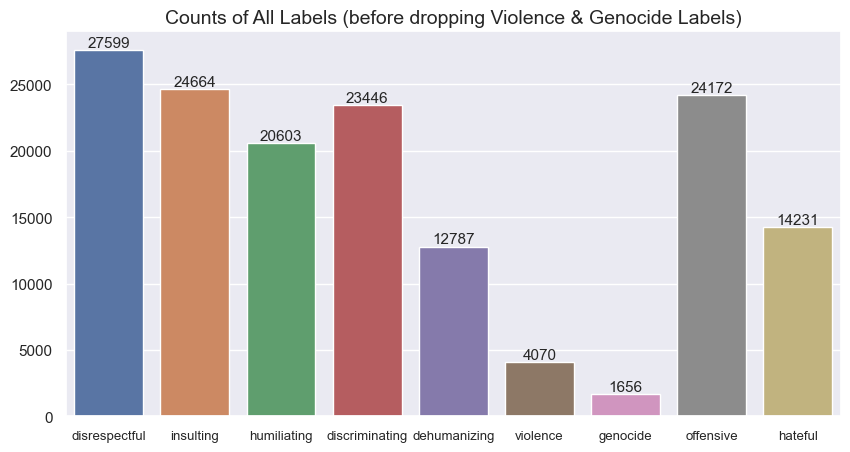

In [25]:
categories = list(label_df.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(10,5))
ax= sns.barplot(x = categories, y = label_df.sum().values)
plt.title("Counts of All Labels (before dropping Violence & Genocide Labels)", fontsize=14)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=11)
#adding the text labels
rects = ax.patches
labels = label_df.sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=11)
plt.show()

Based on the above graph, the number of violence and genocide labels is extremely disproportionate. Given that there are 39565 unique posts in the dataset, each label only accounts for 10.3% (violence) and 4.1% (genocide). Further visualization of the labels are provided below. Given the imbalance nature of both labels, the preference of the project is to drop them from analysis. 

0    0.897131
1    0.102869
Name: violence, dtype: float64
 


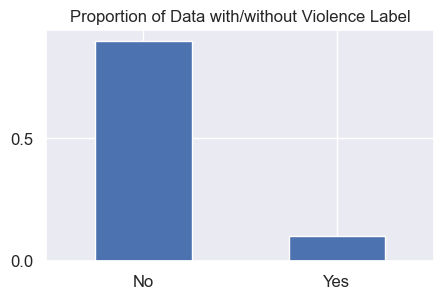

In [26]:
print(score_df['violence'].value_counts(normalize=True))
print(' ')
score_df['violence'].value_counts(normalize=True).plot(kind='bar', figsize=(5,3))
plt.title('Proportion of Data with/without Violence Label', fontsize=12)
plt.xticks(ticks=[0,1], labels=['No', 'Yes'], rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

0    0.958145
1    0.041855
Name: genocide, dtype: float64
 


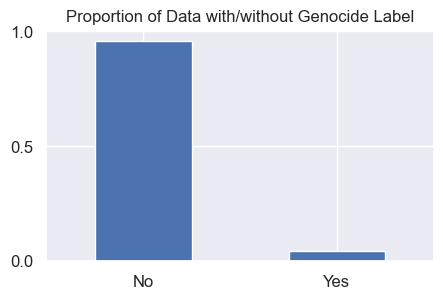

In [27]:
print(score_df['genocide'].value_counts(normalize=True))
print(' ')
score_df['genocide'].value_counts(normalize=True).plot(kind='bar', figsize=(5,3))
plt.title('Proportion of Data with/without Genocide Label', fontsize=12)
plt.xticks(ticks=[0,1], labels=['No', 'Yes'], rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [28]:
# Remove violence and genocide labels
label_df.drop(columns=['violence','genocide'], inplace = True)
score_df.drop(columns=['violence','genocide'], inplace = True);

Having dropped both labels from the dataset, the multi-label classification task will reduce from 9 to 7 labels accordingly.

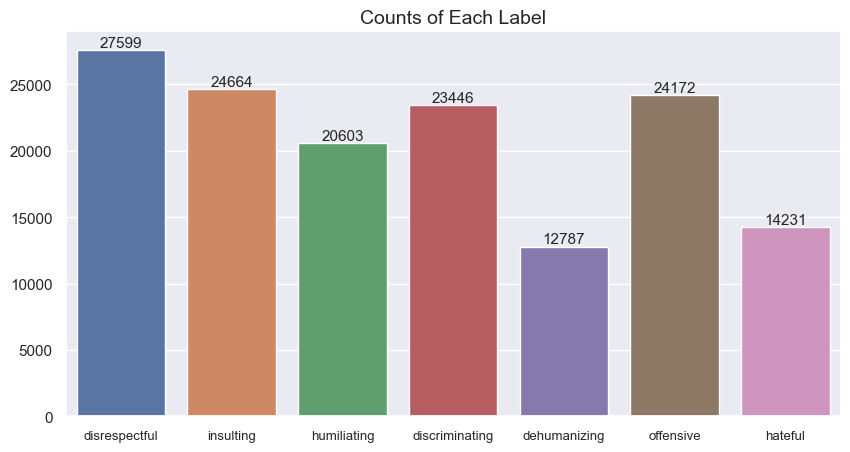

In [29]:
categories = list(label_df.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(10,5))
ax= sns.barplot(x = categories, y = label_df.sum().values)
plt.title("Counts of Each Label", fontsize=14)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=11)
#adding the text labels
rects = ax.patches
labels = label_df.sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=11)
plt.show()

### Q3: What is the breakdown of posts with multi-labels? 

Given the count of labels, it is also worth exploring the breakdown of posts with multi-labels. An overview is provided in the following graph. 

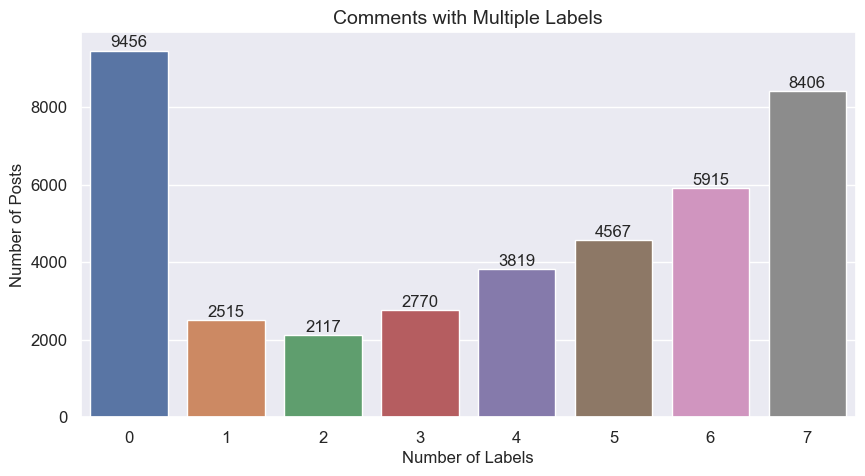

In [30]:
rowSums = label_df.sum(axis=1)
multiLabel_counts = rowSums.value_counts().sort_index()
sns.set(font_scale = 2)
plt.figure(figsize=(10,5))
ax = sns.barplot(x = multiLabel_counts.index, y = multiLabel_counts.values)
plt.title("Comments with Multiple Labels", fontsize=14)
plt.ylabel('Number of Posts', fontsize=12)
plt.xlabel('Number of Labels', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',fontsize=12)
plt.show()

While most posts are without any labels, the second highest number of posts are found with all labels. A pattern of descending order can also be observed. Hence, this leads the further exploration of the labels in Q4.

### Q4: Are there any correlation between labels? 

Based on the heatmap below, it does seem like the labels are highly correlated to each other. All labels but four pairings, namely dehumanizing-disrespectful, dehumanizing-insulting, dehumanizing-discrimating and dehumanizing-offensive, are able to show strong positive correlation of beyond 0.5. Even though the dehumanizing label tends to show weaker correlation with the other labels, it still fare respectably with a positive correlation of beyond 0.4 across these labels. This implies that a modelling which takes into account of the relationship between the labels might be a useful model to explore. More of this will be shared in the second notebook under the modelling section.

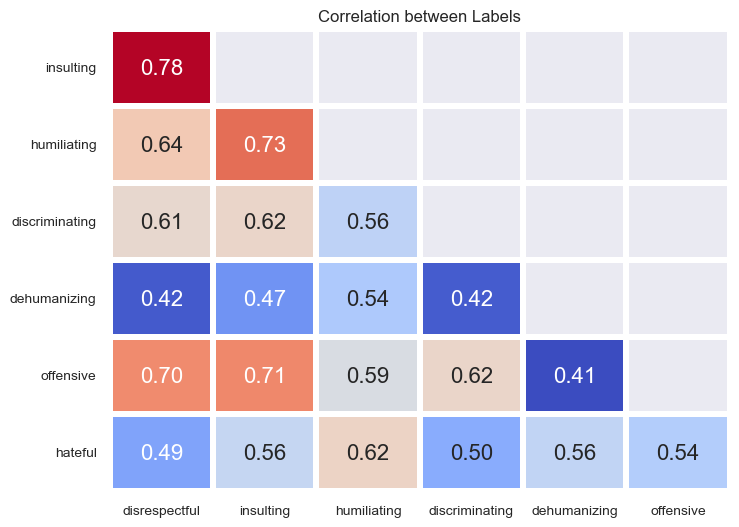

In [31]:
heatmap(label_df)
plt.xticks(rotation=0)
plt.title('Correlation between Labels', fontsize=12);

### 6.2 `annotator_df` Dataset

While the `annotator_df` dataset is of less importance than `score_df`, it is still useful to provide some profile analysis on the annotators.Hence, we shall briefly explore the following questions:
- Q1: How many unique annotators are there in the dataset?
- Q2: What is the general profile of the annotators?

In [32]:
# Recapping the annotator_df
annotator_df.head(2)

,id,gender,educ,income,ideology,age
0,10873,male,college_grad_ba,<10k,neutral,25.0
1,2790,female,some_college,<10k,neutral,30.0


#### Q1: How many unique posts are there in the dataset?

In [33]:
print(f'Number of Annotators: {annotator_df["id"].nunique()}')

Number of Annotators: 7912


#### Q2: What is the general profile of the annotators?

We shall get a quick sensing of the profile of the annotators by doing visualizations on the information given.

##### - Gender

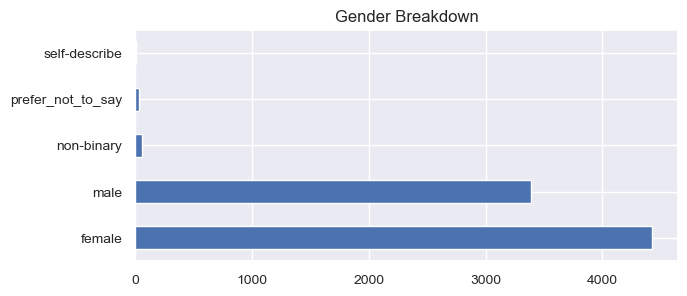

In [34]:
breakdown(annotator_df['gender'])
plt.title('Gender Breakdown', fontsize=12);

##### - Education

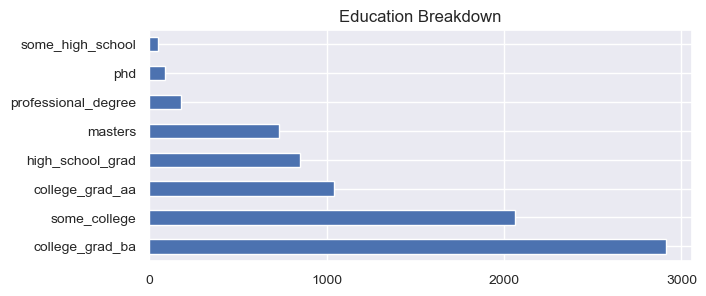

In [35]:
breakdown(annotator_df['educ'])
plt.title('Education Breakdown', fontsize=12);

##### - Income

breakdown(annotator_df['income'])
plt.title('Income Breakdown', fontsize=12);

##### - Ideology

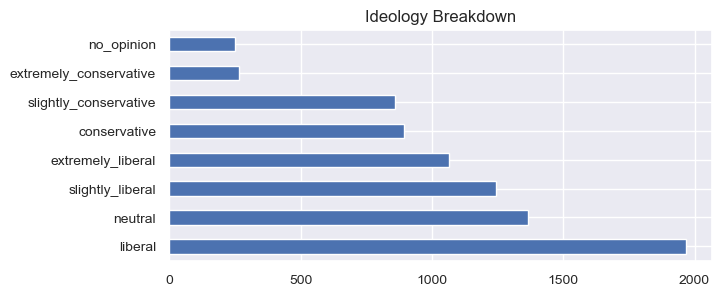

In [36]:
breakdown(annotator_df['ideology'])
plt.title('Ideology Breakdown', fontsize=12);

##### - Age

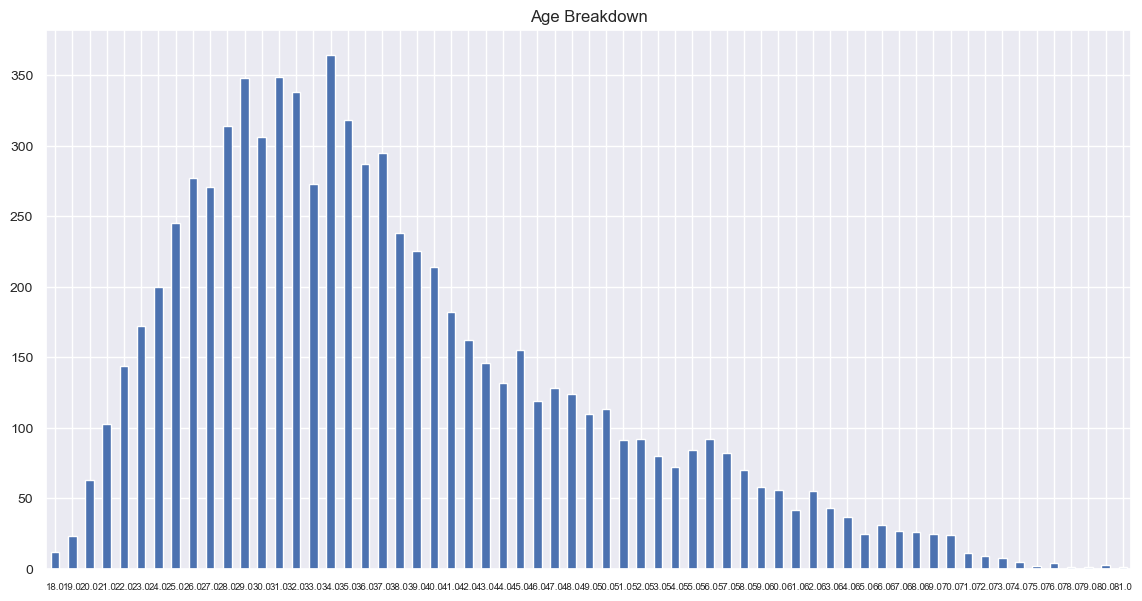

In [37]:
annotator_df['age'].value_counts().sort_index().plot(kind='bar', figsize=(14,7))
plt.title('Age Breakdown', fontsize=12)
plt.xticks(fontsize=7, rotation = 0)
plt.yticks(fontsize=10);

In summary, the following information can be gleaned from the above graphs:
- There were more female annotators to man annotators;
- Most annotators have at least college education;
- The salary of annotators falls within ten thousands to hundred thousands dollars range;
- Most annotators would consider themselves liberal; and 
- Most annotators were in their late twenties to mid thirties.

## 7. Preparation for Modelling Part 1: Text Processing

In preparation for any NLP classification task, the following standard procedures will be covered:
1. lowercasing of all words;
2. coverting emojis into words;
3. remove website links (specifically html tags); 
4. remove special characters; 
5. apply stemming; and 
6. remove stop words, which are unhelpful for analysis purpose.

Note: Stemming was applied before stop words as it allows for less variation of words to better remove stop words from the text. Another popular approach to the simplication of words is to use lemmatization. Nevertheless, stemming is preferred as a more drastic measure in order to reduce the number of features for modelling.

In [38]:
# Following the above steps
score_df['text'] = score_df['text'].apply(lower_demoji)
score_df['text'] = score_df['text'].apply(nfx.remove_puncts)
score_df['text'] = score_df['text'].apply(nfx.remove_html_tags)
score_df['text'] = score_df['text'].apply(nfx.remove_special_characters)
score_df['text'] = score_df['text'].apply(stemming)
score_df['text'] = score_df['text'].apply(nfx.remove_stopwords)

## 8. Summary of Notebook 1

We shall export the cleaned dataset for multi-label classification modelling in notebook 2.

In [39]:
score_df.to_csv("df_cleaned.csv", index = False)

As a recap, this is an overview of the finalised dataset for modelling:

| Index | Columns | Description |
|:----|:----|:----|
|1| text | Post from various social media platforms for NLP task |
|2| disrespectful | Label: 1 for posts which are disrespectful, 0 for posts which are not |
|3| insulting | Label: 1 for posts which are insulting, 0 for posts which are not  |
|4| humiliating | Label: 1 for posts which are humiliating, 0 for posts which are not  |
|5| dehumanizing | Label: 1 for posts which are dehumanzing, 0 for posts which are not  |
|6| discriminating | Label: 1 for posts which are discriminating, 0 for posts which are not  |
|7| offensive | Label: 1 for posts which are offensive, 0 for posts which are not  |
|8| hateful | Label: 1 for posts which are hateful, 0 for posts which are not  |

In short, this notebook managed to complete the following: 
1. Explained the approach of using chosen dataset to address problem statement;
2. Divided main dataset into `score_df` and `annotator_df` for EDA; 
3. Streamlined the number of labels to seven for multi-label classification modelling;
4. Derived a general profile of annotators; and
5. Processed text data for modelling in the subsequent notebook.